<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [5]:
import torch
from torch.utils.data.dataset import random_split
from torchaudio import datasets

from dcunet.dcunet import DCUnet10
from utils.data import get_data, preprocess, WrappedDataLoader
from utils.train import train, wsdr_fn, wsdr_on_noisy_data, wsdr_on_processed_data

import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
print(torch.cuda.is_available())
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dataset = datasets.VCTK_092(root="data", download=False)

ds_size = len(dataset)
train_i = int(0.1 * ds_size)
train_i += train_i % 2
val_i = int(0.11 * ds_size) - train_i
val_i += val_i % 2
test_i = ds_size - train_i - val_i

train_ds, val_ds, test_ds = random_split(dataset, lengths=[train_i, val_i, test_i],
                                         generator=torch.Generator().manual_seed(42))

batch_size = 1
DEVICE = dev
SAMPLE_RATE = 48000
N_FFT = SAMPLE_RATE * 64 // 1000 + 4
HOP_LENGTH = SAMPLE_RATE * 16 // 1000 + 4
zero_q = 0.9
zero_f = 0.2
one_q = 0.9
one_f = 0.5

train_dl, val_dl, test_dl = get_data(train_ds, val_ds, test_ds, batch_size)
train_dl = WrappedDataLoader(train_dl, preprocess, HOP_LENGTH, dev, 
                             zero_q=zero_q, zero_f=zero_f, one_q=one_q, one_f=one_f)
val_dl = WrappedDataLoader(val_dl, preprocess, HOP_LENGTH, dev, 
                           zero_q=zero_q, zero_f=zero_f, one_q=one_q, one_f=one_f)
test_dl = WrappedDataLoader(test_dl, preprocess, HOP_LENGTH, dev, 
                            zero_q=zero_q, zero_f=zero_f, one_q=one_q, one_f=one_f)

dcunet10 = DCUnet10(N_FFT, HOP_LENGTH).to(dev)

loss_fn = wsdr_fn
optimizer = torch.optim.Adam(dcunet10.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

True


In [9]:
train_losses, test_losses = train(dcunet10, train_dl, val_dl, loss_fn, optimizer, scheduler, 100, dev)

  0%|                                                                                          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [3]:
xi = iter(val_dl)

In [4]:
x = next(xi)
x_noisy = x[0][0]
x_true = x[1][0]
with torch.no_grad():
    x_pred = dcunet10(x_noisy.unsqueeze(0))
x_pred = x_pred / (x_pred.max() - x_pred.min()) * (x_true.max() - x_true.min())

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
  normalized, onesided, return_complex)
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\functional.py:587: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:602.)
  normalized, onesided, length, return_complex)
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorc

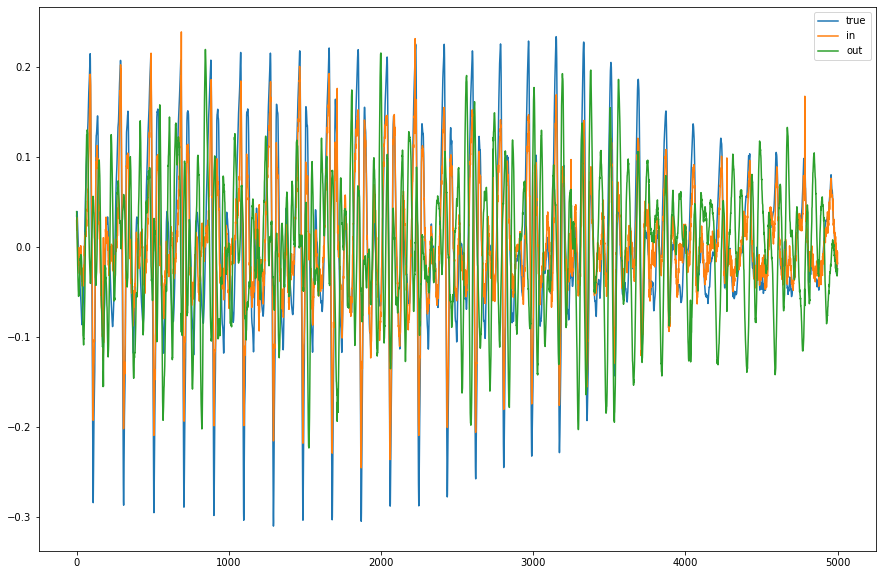

In [5]:
sl = slice(50000, 55000)
plt.figure(figsize=(15,10))
plt.plot(x_true.squeeze().cpu()[sl])

plt.plot(x_noisy.squeeze().cpu()[sl])
plt.plot(x_pred.squeeze().cpu()[sl])

plt.legend(["true", "in", "out"])

In [6]:
display(ipd.Audio(x_noisy.squeeze().cpu(), rate=SAMPLE_RATE));

In [7]:
display(ipd.Audio(x_true.squeeze().cpu(), rate=SAMPLE_RATE));

In [8]:
display(ipd.Audio(x_pred.squeeze().cpu(), rate=SAMPLE_RATE));

In [42]:
torch.save(dcunet10.state_dict(), "new_dcu.pth")

In [3]:
net = DCUnet10(N_FFT, HOP_LENGTH)
net.load_state_dict(torch.load("new_dcu.pth"))

<All keys matched successfully>

In [6]:
wsdr_on_noisy_data(val_dl, dev)

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
  normalized, onesided, return_complex)
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\functional.py:587: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:602.)
  normalized, onesided, length, return_complex)


-0.811278847526742

In [7]:
wsdr_on_processed_data(val_dl, dev, net)

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:653.)
  normalized, onesided, return_complex)


-0.9255741102510391